# Cell Migration: Simulation Study with Calibrated Model

In [1]:
import os
import pickle
from pathlib import Path
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import numpy as np
import math
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from matplotlib.gridspec import GridSpec
from matplotlib.lines import lineStyles
from scipy.stats import circmean, circstd, median_abs_deviation

from summary_stats import reduce_to_coordinates, compute_MSD_lags, turning_angle, angle_degree, velocity

In [2]:
gp = os.getcwd()

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.rate': './CellTypes/CellType/Constant[@symbol="move.duration.rate"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
    'pulse_period': './Global/Constant[@symbol="puls_period"]',
}
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis (energy potential)
    'move.strength': 10.,  # strength of directed motion (energy potential)
    'move.duration.rate': 0.1,  # rate of exponential distribution (1/seconds)
    'cell_nodes_real': 50.,  # area of the cell  (\mu m^2)
}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.rate': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
real_posterior = np.load(f'abc_results_real/posterior_samples.npy')
real_posterior_median = np.median(real_posterior, axis=0)
print(real_posterior_median)
print(np.power(10, real_posterior_median))

models_simulations = {  # 10sec time steps
    'classic': 'cell_movement_v24_10sec',
    'no_chemokine': 'cell_movement_v24-no-chemokine',  # for simulation without chemokine
    'no_persistence': 'cell_movement_v24-no-persistent',  # for simulation without persistent random walk
    'pulsing_chemokine_2': 'cell_movement_v24-puls_prefactor',  # for simulation with pulsing chemokine, time in minutes
    'pulsing_chemokine_5': 'cell_movement_v24-puls_prefactor',
    'pulsing_chemokine_10': 'cell_movement_v24-puls_prefactor',
    'pulsing_chemokine_20': 'cell_movement_v24-puls_prefactor',
    'pulsing_chemokine_30': 'cell_movement_v24-puls_prefactor',
    'pulsing_chemokine_40': 'cell_movement_v24-puls_prefactor',
    'pulsing_chemokine_50': 'cell_movement_v24-puls_prefactor',
    'pulsing_chemokine_60': 'cell_movement_v24-puls_prefactor',
}

# defining the summary statistics function
dt = 10
min_sequence_length = 0
cells_in_population = 143
max_sequence_length = 3600 // dt
def prepare_sumstats(output_morpheus_model) -> dict:
    sim_coordinates = reduce_to_coordinates(output_morpheus_model,
                                            minimal_length=min_sequence_length,
                                            maximal_length=max_sequence_length,
                                            cut_region_of_interest=False
                                            )

    # we now do exactly the same as in the BayesFlow workflow, but here we get only one sample at a time
    data_transformed = np.ones((cells_in_population, max_sequence_length, 3)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    if len(sim_coordinates) != 0:
        # some cells were visible in the simulation
        for c_id, cell_sim in enumerate(sim_coordinates):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_transformed[c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_transformed[c_id, -len(cell_sim['y']):, 1] = cell_sim['y']
            data_transformed[c_id, -len(cell_sim['y']):, 2] = cell_sim['t']
    
    return {'sim': data_transformed}

sumstat = SummaryStatistics(sum_stat_calculator=prepare_sumstats)
models_simulations_list = []
@delayed
def wrapper_fun(model_name, no_pillars=False):
    if no_pillars:
        model_path = models_simulations[model_name] + '_no_pillars.xml'
    else:
        model_path = models_simulations[model_name] + '.xml'
    _par_map_temp = par_map.copy()
    if not model_name.startswith("pulsing_chemokine"):
        # remove the pulse period parameter
        _par_map_temp.pop('pulse_period')
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=_par_map_temp, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat
    )
    sim_dict = {key: p for key, p in zip(obs_pars.keys(), real_posterior_median)}
    if model_name.startswith("pulsing_chemokine"):
        # set the pulse period
        sim_dict['pulse_period'] = np.log10(float(model_name.split('_')[-1]) * 60)  # convert minutes to seconds
    posterior_sim = model(sim_dict)['sim']
    return {model_name: posterior_sim}

NO_PILLARS = False
if NO_PILLARS:
    name_pillars = '_no_pillars'
else:
    name_pillars = ''
if os.path.exists(f'simulation_study_sims{name_pillars}.pickle'):
    with open(f'simulation_study_sims{name_pillars}.pickle', 'rb') as f:
        models_simulations_dicts = pickle.load(f)
else:
    models_simulations_list = Parallel(n_jobs=10, verbose=1)(
        wrapper_fun(model_name, no_pillars=NO_PILLARS) for model_name in
        list(models_simulations.keys())*3
    )
    models_simulations_dicts = [{}, {}, {}]
    for run_i in range(3):
        n = run_i * len(models_simulations)
        for i in range(len(models_simulations)):
            models_simulations_dicts[run_i][list(models_simulations.keys())[i]] =  np.array(list(models_simulations_list[n+i].values()))
    # save the simulations
    with open(f'simulation_study_sims{name_pillars}.pickle', 'wb') as f:
        pickle.dump(models_simulations_dicts, f)

[ 1.54973707  1.45735905 -2.67825268  1.62045869]
[3.54598642e+01 2.86654687e+01 2.09771905e-03 4.17309907e+01]


In [3]:
@delayed
def wrapper_fun_params(param, no_pillars=True):
    if param[0] == 0:
        model_name = 'no_chemokine'
    else:
        model_name = 'no_persistence'
    if no_pillars:
        model_path = models_simulations[model_name] + '_no_pillars.xml'
    else:
        model_path = models_simulations[model_name] + '.xml'
    _par_map_temp = par_map.copy()
    if not model_name.startswith("pulsing_chemokine"):
        # remove the pulse period parameter
        _par_map_temp.pop('pulse_period')
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=_par_map_temp, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat
    )
    sim_dict = {key: p for key, p in zip(obs_pars.keys(), real_posterior_median)}
    sim_dict['gradient_strength'] = param[0]  # replace param
    sim_dict['move.strength'] = param[1]
    if model_name.startswith("pulsing_chemokine"):
        # set the pulse period
        sim_dict['pulse_period'] = np.log10(float(model_name.split('_')[-1]) * 60)  # convert minutes to seconds
    posterior_sim = model(sim_dict)['sim']
    return posterior_sim * 1.3  # scale to micrometers

n_vals = 11
bounds_gs = np.log10(limits['gradient_strength'])
bounds_ms = np.log10(limits['move.strength'])
params_gs = np.array([np.linspace(bounds_gs[0], bounds_gs[1], n_vals),
                      np.zeros(n_vals)*real_posterior_median[1]]).T
params_ms= np.array([np.zeros(n_vals)*real_posterior_median[0],
                     np.linspace(bounds_ms[0], bounds_ms[1], n_vals)]).T
params = np.concatenate((params_gs, params_ms), axis=0)

if os.path.exists(f'simulation_study_sims_strength.pickle'):
    with open(f'simulation_study_sims_strength.pickle', 'rb') as f:
        param_simulations_list = pickle.load(f)
else:
    param_simulations_list = Parallel(n_jobs=10, verbose=1)(wrapper_fun_params(p) for p in params)
    # save the simulations
    with open(f'simulation_study_sims_strength.pickle', 'wb') as f:
        pickle.dump(param_simulations_list, f)
param_simulations_list = np.stack(param_simulations_list)

In [4]:
from summary_stats import compute_msd

msd = []
msd_std = []
for i in range(n_vals*2):
    msd_c_list = []
    for c in range(143):
        msd_c = compute_msd(dict(x=param_simulations_list[i, c, :, 0],
                                 y=param_simulations_list[i, c, :, 1],
                                 t=param_simulations_list[i, c, :, 2]),
                               dt=dt, all_time_lags=True)
        msd_c_list.append(msd_c)
    msd.append(np.mean(msd_c_list, axis=0))
    msd_std.append(np.std(msd_c_list, axis=0))
msd = np.array(msd)
msd_std = np.array(msd_std)

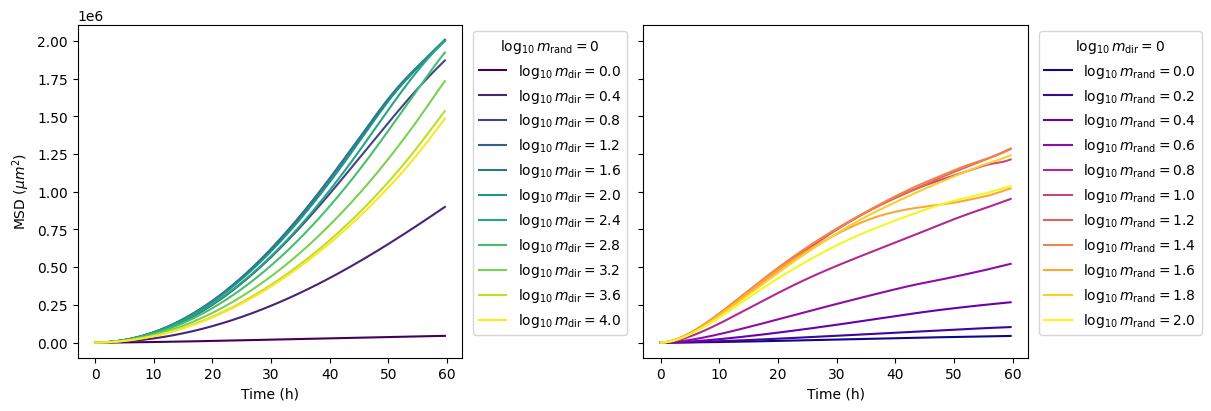

In [5]:
fig, ax = plt.subplots(1, 2, sharex='row', sharey='row', layout='constrained', figsize=(12, 4))

lag_time = np.arange(msd.shape[1])*dt/60
# gradients
colors_left = plt.cm.viridis(np.linspace(0, 1, n_vals))
colors_right = plt.cm.plasma(np.linspace(0, 1, n_vals))

for i, c in enumerate(colors_left):
    ax[0].errorbar(x=lag_time, y=msd[i], #yerr=msd_std[i],
                   color=c, label=r'$\log_{10} m_{\text{dir}}=$'+f'${params[i,0]:.1f}$')
ax[0].legend(bbox_to_anchor=(1.01, 1), title=r'$\log_{10} m_{\text{rand}}=0$')
ax[0].set_xlabel('Time (h)')
ax[0].set_ylabel(r'MSD ($\mu m^2$)')
#ax[0].ticklabel_format(axis='y', style='sci', scilimits=(3,3))
#ax[0].plot(lag_time, lag_time*2*2*1e3, '--', color='black')

for i, c in zip(range(n_vals, n_vals*2), colors_right):
    ax[1].errorbar(x=lag_time, y=msd[i], #yerr=msd_std[i],
                   color=c, label=r'$\log_{10} m_{\text{rand}}=$'+f'${params[i,1]:.1f}$')
#ax[1].set_yscale('log')
#ax[1].set_xscale('log')
ax[1].legend(bbox_to_anchor=(1.01, 1), title=r'$\log_{10} m_{\text{dir}}=0$')
ax[1].set_xlabel('Time (h)')
plt.show()

# Analysis with Real Data Calibrated Model

In [ ]:
# # # Set publication-quality matplotlib parameters
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'sans-serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'legend.frameon': False,
    #'figure.dpi': 300,
    #'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.transparent': False
})


# ────────────────────────────────
#  Core mathematical functions
# ────────────────────────────────

def msd_with_sem(trajs):
    """
    Calculate MSD with standard error of the mean.

    Parameters:
        trajs : array (n_cells, T, 2)

    Returns:
        msd_mean : array (T,) - mean MSD
        msd_sem : array (T,) - standard error of mean
        lags : array (T,) - lag times
    """
    n_cells, T = trajs.shape[:2]
    lags = np.arange(T)[1:]  # skip lag 0

    msd_individual = compute_MSD_lags(trajs)
    msd_mean = np.mean(msd_individual, axis=0)
    msd_sem = np.std(msd_individual, axis=0) / np.sqrt(n_cells)
    return msd_mean, msd_sem, lags


def fit_power_law(x, y, x_range=None):
    """
    Fit power law: y = A * x^α

    Returns:
        alpha : float - power law exponent
        A : float - prefactor
        r_squared : float - goodness of fit
    """
    if x_range is not None:
        mask = (x >= x_range[0]) & (x <= x_range[1])
        x_fit, y_fit = x[mask], y[mask]
    else:
        x_fit, y_fit = x, y

    # Remove zeros and invalid values
    valid = (x_fit > 0) & (y_fit > 0) & np.isfinite(x_fit) & np.isfinite(y_fit)
    x_fit, y_fit = x_fit[valid], y_fit[valid]

    if len(x_fit) < 2:
        return np.nan, np.nan, np.nan

    # Log-linear fit
    log_x, log_y = np.log10(x_fit), np.log10(y_fit)
    coeffs = np.polyfit(log_x, log_y, 1)
    alpha, log_A = coeffs[0], coeffs[1]
    A = 10**log_A

    # Calculate R²
    y_pred = A * x_fit**alpha
    ss_res = np.sum((y_fit - y_pred)**2)
    ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

    return alpha, A, r_squared


def calculate_directional_stats(angles):
    """Calculate circular statistics for turning angles."""
    if len(angles) == 0:
        return {'mean': np.nan, 'std': np.nan, 'concentration': np.nan}

    mean_angle = circmean(angles)
    std_angle = circstd(angles)

    # Calculate concentration parameter (inverse of circular variance)
    R = np.abs(np.mean(np.exp(1j * angles)))
    concentration = R / (1 - R) if R < 1 else np.inf

    return {
        'mean': mean_angle,
        'std': std_angle,
        'concentration': concentration,
        'mean_resultant_length': R
    }


# ────────────────────────────────────────────────────────────────────
# main plotting routine
# ────────────────────────────────────────────────────────────────────
def plot_trajectory_overlay(
        ax, trajs, *, n_show=50, alpha=0.6, colormap='tab10',
        show_start_end=True, scale_bar=None, show_image=True,
        x_min=None, x_max=None, y_min=None, y_max=None,
        img_path='Cell_migration_grid_v3_final2_invers.tiff', plot_legend=True):
    """
    Overlay trajectories with start/end markers and a *cropped & scaled*
    background image that never alters the data limits.

    Parameters are identical to your earlier version.
    """
    # ─────────────── trajectories & markers ────────────────
    n_show = min(n_show, len(trajs))
    cmap   = plt.colormaps.get_cmap(colormap)
    colours = cmap(np.linspace(0, 1, n_show))

    for i, tr in enumerate(trajs[:n_show]):
        ax.plot(tr[:, 0], tr[:, 1],
                color=colours[i], lw=0.8, alpha=alpha, zorder=2)

        handles = []
        if show_start_end:
            h = ax.scatter(*tr[0],  c='black', alpha=0.7, s=15,  marker='o', lw=0.5, zorder=3, label='Start')
            handles.append(h)
            h = ax.scatter(*tr[-1], c='black', alpha=0.7, s=15, marker='x', lw=0.5, zorder=3, label='End of trajectory')
            handles.append(h)

    # ─────────────── background image (cropped) ────────────────
    if x_min is None:
        x_min, x_max = ax.get_xlim()
    if y_min is None:
        y_min, y_max = ax.get_ylim()
    if show_image and Path(img_path).exists():
        # read image so its aspect matches the data window
        img = plt.imread(img_path)
        ax.imshow(img,
                  origin='lower',
                  #extent=[x_min, x_max, y_min, y_max],
                  aspect='auto',          # preserve pixel squares
                  zorder=0,
                  interpolation=['bicubic', 'bessel', 'hermite', 'nearest', 'spline16', 'mitchell', 'bilinear', 'sinc', 'none', 'gaussian', 'blackman', 'spline36', 'hanning', 'kaiser', 'lanczos', 'antialiased', 'hamming', 'catrom', 'quadric'][14]) # keep grid sharp

    # apply limits so nothing moves
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # ─────────────── cosmetics ────────────────
    if len(handles) > 0 and plot_legend:
        ax.legend(handles=handles, loc='lower center', ncols=2, bbox_to_anchor=(0.5, -0.7))

    if scale_bar is not None:
        add_scale_bar(ax, scale_bar)   # your own helper

    ax.set_aspect('equal')
    #ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')
    ax.grid(True, alpha=0.3, lw=0.5)


def plot_polar_rose(ax, angles, bins=36, show_arrow=False, color='steelblue'):
    """Enhanced polar histogram with statistical annotations."""
    if len(angles) == 0:
        ax.text(0.5, 0.5, 'No valid angles', transform=ax.transAxes,
                ha='center', va='center')
        return

    # Create histogram
    counts, bin_edges = np.histogram(angles, bins=bins, range=(-np.pi, np.pi))
    widths = np.diff(bin_edges)
    centers = bin_edges[:-1] + widths/2

    # Normalize counts to probability density
    density = counts / (np.sum(counts) * widths)

    # Plot bars
    ax.bar(centers, density, width=widths, bottom=0.0,
                  align='center', alpha=1, color=color, edgecolor='white', linewidth=0.5)

    # Calculate and display statistics
    if show_arrow:
        stats = calculate_directional_stats(angles)

        # Add mean direction arrow
        if not np.isnan(stats['mean']):
            max_density = np.max(density)
            if max_density > 0.3:
                ax.arrow(stats['mean'], 0, 0, max_density * 0.8,
                        head_width=0.1, head_length=max_density*0.1,
                        fc='red', ec='red', linewidth=2, alpha=0.8, zorder=5)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_ylim(0, 0.5) #np.max(density) * 1.1)
    #ax.set_xlabel('Turning angle')
    ax.text(-0.6, 0.5, 'Probability density', transform=ax.transAxes,
                horizontalalignment='left',  # Align text to the left
                verticalalignment='center',  # Align text to the top
                rotation=90)
    ax.set_yticklabels([])

    # Add angle labels
    ax.set_thetagrids(np.arange(0, 360, 45),
                     labels=['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°'])


def plot_msd_analysis(ax, trajs, colour_by_regime=True, plot_legend=True):
    """
    MSD ± SEM on log–log axes, optional power-law fits, and (if
    colour_by_regime=True) the MSD line segments are coloured according
    to the local log-slope:
        • red   → sub-diffusive   (α < 0.8)
        • green → diffusive       (0.8 ≤ α ≤ 1.2)
        • blue  → super-diffusive (α > 1.2)
    """
    # ------------------------------------------------------------------
    # 1. ensemble MSD and SEM
    # ------------------------------------------------------------------
    msd_mean, msd_sem, lags = msd_with_sem(trajs)          # your helper
    tau           = lags[1:]                               # skip τ = 0
    msd_vals      = msd_mean[1:]
    msd_errors    = msd_sem[1:]

    # ------------------------------------------------------------------
    # 2. regime colouring (optional)
    # ------------------------------------------------------------------
    if colour_by_regime:
        # log-space derivatives
        log_tau = np.log10(tau)
        log_msd = np.log10(msd_vals)
        slopes  = np.gradient(log_msd, log_tau)

        # masks for each regime
        masks   = {
            'sub'  : slopes < 0.75,
            'diff' : (slopes >= 0.75) & (slopes <= 1.25),
            'super': slopes > 1.25
        }
        colours = {'sub': '#D55E00', 'diff': '#0072B2', 'super': '#009E73'}
        #labels  = {'sub':  r'Sub-diff.  (α<0.8)',
        #           'diff': r'Diffusive (0.8≤α≤1.2)',
        #           'super':r'Super-diff. (α>1.2)'}
        labels  = {'sub':  r'Sub-diff.',
                   'diff': r'Diffusive',
                   'super':r'Super-diff.'}
        # make sure all labels are shown
        for key, label in labels.items():
            if label is not None:
                ax.errorbar([], [], yerr=[], color=colours[key], lw=2, label=label)

        # plot separate line segments, one per regime
        for key, mask in masks.items():
            if not np.any(mask):
                continue
            # break into contiguous runs
            idx     = np.where(mask)[0]
            splits  = np.where(np.diff(idx) > 1)[0] + 1
            chunks  = np.split(idx, splits)

            for chunk in chunks:
                ax.errorbar(tau[chunk], msd_vals[chunk],
                            yerr=msd_errors[chunk],
                            color=colours[key],
                            marker='o', ms=3, alpha=0.8)

    else:
        # single-colour MSD
        ax.errorbar(tau, msd_vals, yerr=msd_errors,
                    color='navy', marker='o', ms=3, alpha=0.8, label='MSD ± SEM')

    # ------------------------------------------------------------------
    # 3. log–log axes & cosmetics
    # ------------------------------------------------------------------
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlabel('Lag time τ (time steps)')
    ax.set_ylabel('MSD(τ)  (μm²)')
    ax.grid(True, which='both', alpha=0.3)
    ax.set_ylim(1, 1e7)
    if plot_legend:
        ax.legend(loc='lower center', ncols=3, bbox_to_anchor=(0.5, -0.7))


def add_scale_bar(ax, length, units='μm', loc='lower right'):
    """Add a scale bar to the plot."""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if loc == 'lower right':
        x = xlim[1] - (xlim[1] - xlim[0]) * 0.15
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.1
    else:
        x = xlim[0] + (xlim[1] - xlim[0]) * 0.05
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.1

    ax.plot([x-length, x], [y, y], 'k-', linewidth=3)
    ax.text(x-length/2, y + (ylim[1]-ylim[0])*0.02, f'{length} {units}',
            ha='center', va='bottom', fontsize=8)


def plot_run_length_distribution(ax, trajs, angle_threshold=30):
    """
    Plot the survival distribution P(run length > ℓ) for trajectories.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to draw on.
    trajs : array-like, shape (n_cells, T, 2)
        Trajectories of individual cells.
    angle_threshold : float, default=30
        Maximum turning angle (in degrees) for steps to be considered within a 'run'.
    """
    threshold = np.deg2rad(angle_threshold)
    run_lengths = []

    for tr in trajs:
        # Compute turning angles between successive displacement vectors
        angs = turning_angle({'x': tr[:, 0], 'y': tr[:, 1]})
        mask = np.abs(angs) < threshold

        # Pad with zeros to find contiguous True segments
        padded = np.concatenate(([0], mask.astype(int), [0]))
        diff = np.diff(padded)
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        lengths = ends - starts
        run_lengths.extend(lengths)

    run_lengths = np.array(run_lengths)
    if run_lengths.size == 0:
        raise ValueError("No runs detected. Check `angle_threshold` or trajectory data.")

    # Compute survival curve: for each unique run length ℓ, P(run > ℓ)
    unique_lengths = np.unique(run_lengths)
    survival = np.array([np.sum(run_lengths > L) / run_lengths.size for L in unique_lengths])

    # Plot as a step function on log-log axes
    ax.step(unique_lengths, survival, where='post', linewidth=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Run length (steps)')
    ax.set_ylabel('P(run length > ℓ)')
    ax.grid(True, which='both', alpha=0.3)
    ax.set_ylim(0.0001, 1)


def plot_velocity(ax, traj, pulse_interval=30.0, show_pulse=True,
                  line_kwargs=None, pulse_kwargs=None):
    """
    Plot instantaneous speed and mark pulse onsets every `pulse_interval` seconds.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on.
    traj : array-like, shape (T, 2)
        Single trajectory (x, y) over time.
    pulse_interval : float, default=30.0
        Seconds between pulse events.
    show_pulse : bool, default=True
        Whether to show pulse markers.
    line_kwargs : dict, optional
        Additional kwargs passed to ax.plot for the speed trace.
    pulse_kwargs : dict, optional
        Additional kwargs passed to ax.axvline and ax.scatter for pulse markers.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    # Compute speed and time axis
    speeds = velocity({'x': traj[:, 0], 'y': traj[:, 1]}, dt=dt)
    times = np.arange(len(speeds)) * dt

    # Default styling
    if line_kwargs is None:
        line_kwargs = {'color': 'C0', 'linewidth': 1.5, 'label': 'Speed'}
    if pulse_kwargs is None:
        pulse_kwargs = {'color': 'C1', 'linestyle': '--', 'alpha': 0.7}

    # Plot speed trace
    ax.plot(times, speeds, **line_kwargs)

    # Determine pulse event times and indices
    max_time = times[-1]
    pulse_times = np.arange(0, max_time + pulse_interval, pulse_interval)
    pulse_indices = (pulse_times / dt).astype(int)
    pulse_indices = pulse_indices[pulse_indices < len(speeds)]

    # Mark pulses: vertical lines and point markers
    if show_pulse:
        for pt in pulse_times:
            if pt <= max_time:
                ax.axvline(pt, **pulse_kwargs)

        # Scatter at exact pulse points
        ax.scatter(times[pulse_indices], speeds[pulse_indices],
                   **{**pulse_kwargs, **{'marker': 'o', 's': 30, 'label': 'Pulse onset'}})

    # Labels & grid
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Speed (μm/min)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    ax.set_ylim(0, 700)
    return ax



def sequence_enters_circle(center, radius, points):
    x0, y0 = center
    return any(
        math.hypot(x - x0, y - y0) <= radius
        for x, y in points
    )


def count_sequences_entering(center, radius, sequences):
    return sum(
        1 for seq in sequences
        if sequence_enters_circle(center, radius, seq)
    )



# ────────────────────────────────
#  Master plotting function
# ────────────────────────────────
def create_publication_figure(trajs,
                             save_path=None,
                             figure_size=(3.5, 1.5),
                             n_trajectories=50,
                             rose_bins=36,
                             scale_bar_length=None,
                             show_image=True,
                             plot_legend=False,
                             show_pulse=False):
    """
    Create publication-quality figure with enhanced visualizations.

    Parameters:
        trajs : array (n_cells, T, 2) - trajectory data
        save_path : str - output file path
        figure_size : tuple - figure dimensions in inches
        n_trajectories : int - number of trajectories to show in overlay
        rose_bins : int - number of bins for polar histogram
        scale_bar_length : float - length of scale bar in micrometers
        show_image : bool - whether to show background image
        plot_legend : bool - whether to plot legend
        show_pulse : bool - whether to show pulse markers in velocity plot
    """
    # Calculate turning angles for all trajectories
    all_angles = []
    for traj in trajs:
        angles = turning_angle({'x': traj[:, 0], 'y': traj[:, 1]})
        if len(angles) > 0:
            all_angles.extend(angles)
    all_angles = np.array(all_angles)

    # Create figure with custom layout
    fig = plt.figure(figsize=figure_size, layout='constrained')
    gs = GridSpec(1, 2, figure=fig)

    # Panel A: Trajectory overlay
    ax1 = fig.add_subplot(gs[0, 0])
    x_min, x_max = 1172//2-550, 1172//2+550
    y_min, y_max = 600, 1900
    plot_trajectory_overlay(ax1, trajs, n_show=n_trajectories,
                            x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
                           scale_bar=scale_bar_length, show_image=show_image, plot_legend=plot_legend)

    # Panel B: Turning angle distribution
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    plot_polar_rose(ax2, all_angles, bins=rose_bins)

    # Panel C: MSD analysis or Run-length distribution panel or velocity distribution
    #ax3 = fig.add_subplot(gs[0, 2])
    #plot_msd_analysis(ax3, trajs, plot_legend=plot_legend)
    #plot_run_length_distribution(ax3, trajs, angle_threshold=30)
    #plot_velocity(ax3, trajs, show_pulse=show_pulse)

    # Save figure
    if not save_path is None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    if len(all_angles) > 0:
        # Print summary statistics
        print(f"\n=== Analysis Summary ===")
        stats = calculate_directional_stats(all_angles)
        print(f"Mean turning angle: {np.degrees(stats['mean']):.1f}°")
        print(f"Turning angle std: {np.degrees(stats['std']):.1f}°")
        print(f"Directional persistence (R): {stats['mean_resultant_length']:.3f}")
    return fig

In [ ]:
start_time = 180 // dt  # 3min
for models_simulations in models_simulations_dicts:
    for model_name, sim_data in models_simulations.items():
        print(model_name)
        fig = create_publication_figure(
            sim_data[0, :, start_time:, :2],
            save_path=f'plots/simulation_study_{model_name}{name_pillars}.svg',
            n_trajectories=50,
            show_image=False if NO_PILLARS else True,
            #plot_legend=True if model_name == 'classic' else False
            #show_pulse=True if model_name == 'pulsing_chemokine' else False
        )
        plt.show()
    break

In [ ]:
with open(f'simulation_study_sims.pickle', 'rb') as f:
    models_simulations_dicts = pickle.load(f)
with open(f'simulation_study_sims_no_pillars.pickle', 'rb') as f:
    models_simulations_dicts_no_pillars = pickle.load(f)

In [ ]:
center = (1172.5/2, (1500+1500/2+270)/1.31)
radius = 550
colors = (
    "#3B8EA5",
    "#E4572E"
)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(6, 2.5), layout='constrained')
plot_labels = []
for k in models_simulations.keys():
    if k == 'classic':
        plot_labels.append(3600)
    elif k == 'no_chemokine':
        plot_labels.append(0)
    elif k == 'no_persistence':
        plot_labels.append(3600)
    elif k.startswith('pulsing_chemokine'):
        plot_labels.append(float(k.split("_")[-1])*60)
    else:
        print(k, 'not added')
plot_labels = np.array(plot_labels)
plot_index = [1,3,4,5,6,7,8,9,0]

for label, color, dicts in zip(['With Pillars', 'Without Pillars'],
        colors,
        [models_simulations_dicts, models_simulations_dicts_no_pillars]
):
    count_dict = {k: [] for k in dicts[0].keys()}
    for models_simulations in dicts:
        for model_name, sim_data in models_simulations.items():
            count = count_sequences_entering(center, radius, sequences=sim_data[0, :, start_time:, :2])
            count_dict[model_name].append(count)
    counts = np.stack(list(count_dict.values()), axis=1)

    counts_end_trajs_median = np.median(counts/143, axis=0)[plot_index]
    counts_end_trajs_mad = median_abs_deviation(counts/143, axis=0)[plot_index]

    print(np.array(list(count_dict.keys()))[plot_index])
    ax[0].errorbar(x=plot_labels[plot_index] / 60, y=counts_end_trajs_median,
                 yerr=counts_end_trajs_mad, label=label,
                 fmt='o-', capsize=5, elinewidth=1.5, markeredgewidth=1.5,
                 color=color, ecolor=color, alpha=0.75)
ax[0].set_ylabel('Arrival in\n'+r'chemokine hole ($\%$)', fontsize=13)
ax[0].set_xlabel('Time of initial pulse\nof chemokine (min)', fontsize=13)
ax[0].grid(True, alpha=0.5)
ax[0].legend(ncols=1, fontsize=13, loc='upper right')
#plt.savefig(f'plots/simulation_study_count_pulse.pdf')

plot_index = [0,1,2]
plot_labels = ['Chemokine', 'No chemokine', 'No persistence']

#plt.figure(figsize=(5, 3), layout='constrained')
for label, color, dicts in zip(['With Pillars', 'Without Pillars'],
        colors,
        [models_simulations_dicts, models_simulations_dicts_no_pillars]
):
    count_dict = {k: [] for k in dicts[0].keys()}
    for models_simulations in dicts:
        for model_name, sim_data in models_simulations.items():
            count = count_sequences_entering(center, radius, sequences=sim_data[0, :, start_time:, :2])
            count_dict[model_name].append(count)
    counts = np.stack(list(count_dict.values()), axis=1)

    counts_end_trajs_median = np.median(counts/143, axis=0)[plot_index]
    counts_end_trajs_mad = median_abs_deviation(counts/143, axis=0)[plot_index]

    print(np.array(list(count_dict.keys()))[plot_index])
    ax[1].errorbar(x=np.arange(len(plot_index)), y=counts_end_trajs_median,
                 yerr=counts_end_trajs_mad, #label=label,
                 fmt='o-', capsize=5, elinewidth=1.5, markeredgewidth=1.5,
                 color=color, ecolor=color, alpha=0.75)
#ax[1].set_ylabel('Percentage of cells in final circle')
#ax[1].set_xlabel('Simulation setup')
ax[1].set_xticks(ticks=np.arange(len(plot_index)), labels=plot_labels, rotation=15, fontsize=13)
ax[1].grid(True, alpha=0.5)
#ax[0].legend(bbox_to_anchor=(0.5, -0.12), loc='lower center', ncols=2, fontsize=12)
plt.savefig(f'plots/simulation_study_count.pdf', bbox_inches='tight')
plt.show()

In [ ]:
from summary_stats import compute_summary_stats

In [ ]:
time_step = 20
simulation_name = 'classic'

# plot statistics over time
fig, ax = plt.subplots(1, 4, layout='constrained', figsize=(10, 1.5))
for j, test_sim in enumerate([models_simulations_dicts[0][simulation_name], models_simulations_dicts_no_pillars[0][simulation_name]]):
    time_points = np.arange(10, test_sim.shape[2]+1, step=time_step)
    statistics_time = []
    for t in time_points:
        msd_list, ta_list, v_list, ad_list = compute_summary_stats(test_sim[0, :, :t], dt=dt)
        d = np.mean(msd_list), np.std(msd_list)
        ta = np.mean(ta_list), np.std(ta_list)
        v = np.mean(v_list), np.std(v_list)
        ad = np.mean(ad_list), np.std(ad_list)
        statistics_time.append((d, ta, v, ad))

    for i in range(4):
        ax[i].errorbar(time_points*dt/60, [s[i][0] for s in statistics_time],
                       yerr=[s[i][1] for s in statistics_time], fmt='-o', color=colors[j], alpha=0.5)
        if i == 0:
            ax[i].set_ylabel(r'Displacement')
        elif i == 1:
            ax[i].set_ylabel(r'Turning Angle')
        elif i == 2:
            ax[i].set_ylabel(r'Velocity')
        elif i == 3:
            ax[i].set_ylabel(r'Angle Degree')
        ax[i].set_xlabel('Time (min)')
labels=['Pillars', 'No Pillars']
fig.legend(labels=labels, loc='upper center', ncols=2, bbox_to_anchor=(0.5, -0.0))
#plt.savefig(f'plots/test_sim_statistics_time_sim_study.pdf')
plt.show()

In [ ]:
# plot statistics over time
plot_names = ['Chemokine', 'No chemokine', 'Pulsing 30min', 'No persistence']
fig, ax = plt.subplots(1, 4, layout='constrained', figsize=(12, 2))
for p, sim_dict in enumerate([models_simulations_dicts[0], models_simulations_dicts_no_pillars[0]]):
    d_list = []
    ta_list = []
    v_list = []
    ad_list = []
    for j, sim_key in enumerate(['classic', 'no_chemokine', 'pulsing_chemokine_30', 'no_persistence']):
        _msd_list, _ta_list, _v_list, _ad_list = compute_summary_stats(sim_dict[sim_key][0], dt=dt)
        d = np.median(_msd_list), median_abs_deviation(_msd_list)
        ta = np.median(_ta_list), median_abs_deviation(_ta_list)
        v = np.median(_v_list), median_abs_deviation(_v_list)
        ad = np.median(_ad_list), median_abs_deviation(_ad_list)
        d_list.append(d)
        ta_list.append(ta)
        v_list.append(v)
        ad_list.append(ad)

    for i, stat_list in enumerate([d_list, ta_list, v_list, ad_list]):
        ax[i].errorbar(np.arange(len(stat_list))+p/4, [s[0] for s in stat_list],
                       yerr=[s[1] for s in stat_list], fmt='o', color=colors[p], alpha=0.75)
        if i == 0:
            ax[i].set_ylabel(r'Displacement', fontsize=12)
        elif i == 1:
            ax[i].set_ylabel(r'Turning Angle', fontsize=12)
        elif i == 2:
            ax[i].set_ylabel(r'Velocity', fontsize=12)
        elif i == 3:
            ax[i].set_ylabel(r'Angle Degree', fontsize=12)
        #ax[i].set_xlabel('Simulation setup index')
        ax[i].set_xticks(np.arange(len(plot_names)), labels=plot_names, rotation=25, fontsize=12)
labels=['With Pillars', 'Without Pillars']
fig.legend(labels=labels, loc='upper center', ncols=2, bbox_to_anchor=(0.5, 0.06), fontsize=12)
plt.savefig(f'plots/sim_study_statistics.pdf')
plt.show()